# Modelos continuos en Kwant

## Modelo BHZ: breves apuntes de teoría

El modelo BHZ es uno de los más simples y completos para describir los aislantes topológicos 2D. Fue propuesto por Bernevig, Hughes y Zhang en 2006 para describir los pozos de HgTe [arXiv](https://arxiv.org/abs/cond-mat/0611399).

El Hamiltoniano del modelo, expresado en una aproximación continua a baja energía es:

\begin{equation}
H_{BHZ} =
\begin{pmatrix}
E_0 + M -B k^2 & A(k_x+ik_y) & 0 & 0\\
A(k_x-ik_y) & E_0 - M +B k^2 & 0 & 0 \\
0 & 0 & E_0 + M -B k^2 & -A(k_x-ik_y) \\
0 & 0 & -A(k_x+ik_y)  & E_0 - M +B k^2
\end{pmatrix}~,
\end{equation}

donde $E_0 = C-D k^2$ y $k^2 = k_x^2+k_y^2$.

El modelo de BHZ es un Quantum Spin Hall (QSH), la idea intuitiva es que sin un campo externo esperamos encontrar estados de borde polarizados en espín que viajan en las direcciones opuestas dependiendo del espín del estado.

![QSH](Figs/1-QSH.png)

Si consideramos un sistema finito en la dirección $x$ e infinito en $y$, lo que esperamos es obtener una relación de dispersión con estados de borde y además cumpliendo unas propiedades de polarización de espín:

<img src="Figs/1-TopoBands.png" alt="drawing" width="500"/>

El model BHZ (y por ende el QSH) se puede entender también como dos copias de sistemas de QAH con espines opuestos. De hecho, el modelo de Qi-Wu-Zhang (QWZ) describe un QAH y es el bloque superior del BHZ:


\begin{equation}
H_{QWZ} =
\begin{pmatrix}
E_0 + M -B k^2 & A(k_x+ik_y) \\
A(k_x-ik_y) & E_0 - M +B k^2
\end{pmatrix}~,
\end{equation}

Por simplicidad vamos a empezar por este y además en el caso de $E_0=0$

## Sistema de QAH en Kwant

In [1]:
## Importamos los módulos básicos:

import kwant #importamos kwant
import kwant.continuum #para los modelos continuos
import matplotlib.pyplot as plt #pyplot para los plots
import numpy as np #numpy para trabajar con vectores
import scipy as sp #scipy para diagonalizaciones, integraciones, etc
import sympy # importamos sympy para que las matrices se muestren mejor en el notebook
sympy.init_printing()

import tinyarray
# Definimos las matrices de Pauli:
sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

En Kwant, se puede crear el sistema o directamente con el _tight-binding_, o a partir del discretizado de un modelo continuo. Hoy vamos a seguir esta segunda opción.

En este caso, usaremos las herramientas de discretización del proprio Kwant para, a partir del modelo continuo, obtener el tight-bingind.
Es necesario usar la función `fill`para rellenar usando el tight-binding generado automáticamente.

----------------------------
Recordatorio de los pasos de creación de un código básico en Kwant:

    1. Crear un sistema de enlace fuerte “vacío”.
    2. Establecer sus elementos de matriz (onsite) y acoplamientos (*hoppings*).> Esto lo haremos con el discretizado de un modelo CONTINUO
    3. Conectar los contactos *leads* (sistemas de enlace fuerte con simetría traslacional).
    4. Pasar el sistema finalizado a un solucionador (*solver*).
---------------------------

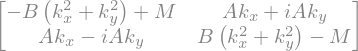

In [2]:
## Escribimos el Hamiltoniano
ham = """
   M * sigma_z - B * (k_x**2 + k_y**2) * sigma_z
   + A * k_x * sigma_x
   - A * k_y * sigma_y
"""
ham = kwant.continuum.sympify(ham)
## Lo mostramos en pantalla:
ham

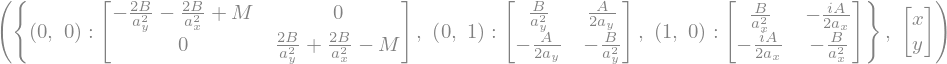

In [3]:
## Podemos obtener la discretización en formato simbólico:
model_symbolic = kwant.continuum.discretize_symbolic(ham)
model_symbolic = kwant.continuum.sympify(model_symbolic)
## También lo mostramos:
# (0,0) significa hoping de (i,j) -> (i+0, j+0) Es una onsite energy
# (0,1) es de (i,j) -> (i+0, j+1) Es el hopping en y
# (1,0) es de (i,j) -> (i+1, j+0) Es el hopping en x
model_symbolic

In [4]:
## Pasos desglosados para crear el sistema:
# >>> Rellenar en clase:

In [5]:
## Función para crear el sistema:

def make_nanoribbon(L, W, a):

    # 1) inicializamos un Builder y discretizamos el modelo
    # discretizamos en una red cuadrada de constante a
    model = kwant.continuum.discretize(ham, grid=a)

    # 2) rellenamos el sistema con sitios de la red

    def shape_nanoribbon(site):
        x, y, = site.pos
        return 0 <= x <= L and 0 <= y <= W

    syst = kwant.Builder()

    ## El comando fill es el que emplearemos en este caso. (0,0) es el sitio por el que se empezará a rellenar el sistema
    syst.fill(model, shape_nanoribbon, (0, 0))

    # 3) Creamos el lead de contacto:
    # En este caso añadimos la simetría traslacional en -x

    lead = kwant.Builder(kwant.TranslationalSymmetry([-a, 0]), )

    def shape_lead(site):
        x, y = site.pos
        return 0 <= y <= W

    lead.fill(model, shape_lead, (0, 0))
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())

    ## Como output sacamos el sistema finalizado y el lead izquierdo
    return syst.finalized(),  lead.finalized()



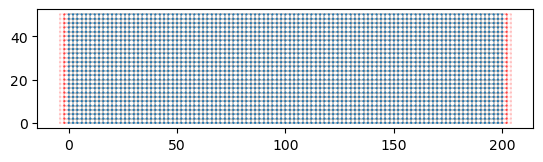

In [21]:
## Creamos una nanocinta de ejemplo
systf, lead = make_nanoribbon(L=200, W=50, a = 2)
kwant.plot(systf);

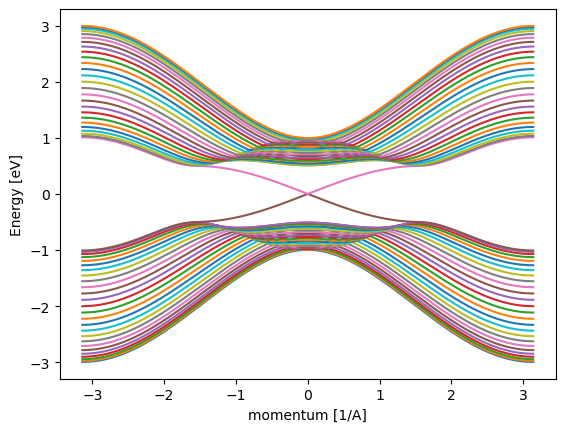

In [7]:
## Veamos alguna propiedad de los leads:
## Primero de forma sencilla mirando las bandas de los leads (que son una nanocinta semi-infinita)
params = dict(A = 1, B = 2,  M = 1)
kwant.plotter.bands(lead, params=params, momenta=np.linspace(-np.pi, np.pi, 201), show=False)
plt.xlabel('momentum [1/A]')
plt.ylabel('Energy [eV]')
plt.show()

**Comentario**: Esta es una forma rápida pero no muy preferible de sacar las relaciones de dispersión. Es mejor sacar el Hamiltoniano del lead y diagonalizarlo con numpy/scipy. Véase el tutorial 1c.

##  <span style="color:orange">Ejercicio 1: </span>
Haz cambios en los parámetros para obtener una fase sin estados de borde.
*Pista:* Tiene que ver con los signos relativos de M y B

##  <span style="color:orange">Ejercicio 2: </span>
Haz una copia de este notebook e implementa el BHZ en vez del modelo de QWZ, se parecen las relaciones de dispersión?

*Pista:* los productos de kronecker de las matrices de Pauli se escriben así: `kron(sigma_x, sigma_y)`

## Conductancia y funciones de onda de scattering:

A continuación calculamos la conductancia, a través de `smatrix` y las funciones de onda de scattering.


In [8]:
## CONDUCTANCIA: Desglose de los comandos en clase
# >>>


def conductance(systf, energies, params, lead_out, lead_in, plot = True):
    cond = []
    ## compute the scattering matrix for a given energy
    for energy in energies:
        smatrix = kwant.smatrix(systf, params=params, energy=energy)
        cond.append(smatrix.transmission(lead_out, lead_in))
    if plot:
        fig, ax = plt.subplots(1,1,figsize = (8,4))
        ax.plot(energies, cond);
        ax.set( ylabel=  ('Conductance [e^2/h]'), xlabel = ('Energy'))
    return np.array(cond)

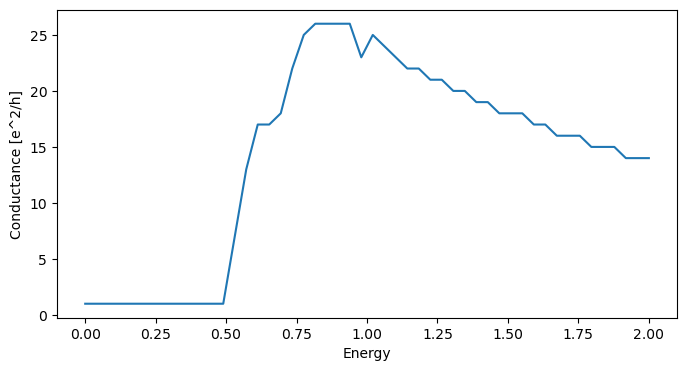

In [9]:
## Ejemplos conductancia:
energies = np.linspace(1e-4, 2.)
cond = conductance(systf, energies, params, lead_out = 1, lead_in = 0)

In [10]:
## DENSIDADES: desglose de los comandos en clase
# >>>

def plot_scatwf(systf, en, params):
    # Calculate the scattering states at energy 'en' coming from the left (numbered as 0) lead and right lead (lead 1)

    density = kwant.operator.Density(systf, sigma_0)
    fig, axs = plt.subplots(1,3,figsize=(16, 5))

    kwant.plotter.bands(systf.leads[0], params = params, ax = axs[0])
    axs[0].axhline(y = en, color= 'k', ls = '--')
    axs[0].set(title=('Bandas de los leads'),
               xlabel=('k'), ylabel=('Energy'))

    axs[1].set(title=('Scat wf from lead 0'))
    wf = kwant.wave_function(systf, energy=en, params=params)(0) #lead = 0
    psi2 = np.sum([density(wf_mode) for wf_mode in wf], axis = 0)
    kwant.plotter.density(systf, psi2, ax = axs[1], cmap = 'Purples')

    axs[2].set(title=('Scat wf from lead 1'))
    wf = kwant.wave_function(systf, energy=en, params=params)(1) #lead = 1
    psi2 = np.sum([density(wf_mode) for wf_mode in wf], axis = 0)
    kwant.plotter.density(systf, psi2, ax = axs[2], cmap = 'Purples')

    [ax.set(xlabel=('x'), ylabel=('y')) for ax in axs[1:]]
    fig.tight_layout()

    return fig


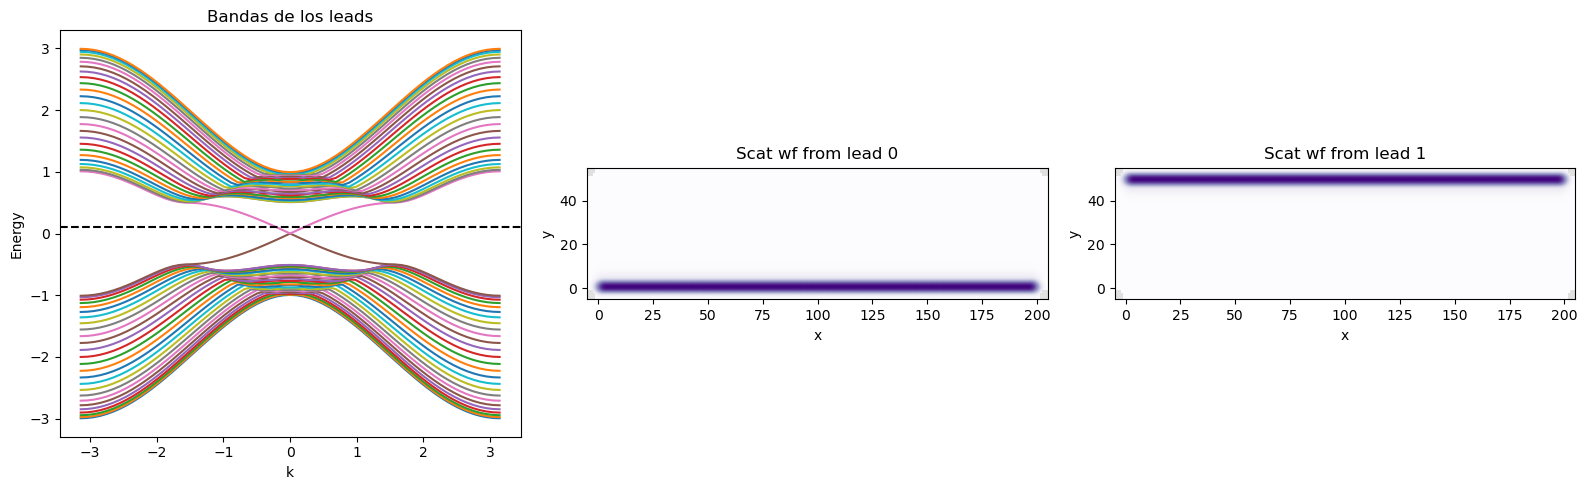

In [11]:
## Ejemplos:
params = dict(A = 1, B = 2,  M = 1)
en = 0.1
fig = plot_scatwf(systf, en, params)

##  <span style="color:orange">Ejercicio 3: </span>
Repite estas cuentas para el caso del BHZ y para rangos de parámetros topoloógicos y triviales


##  <span style="color:orange">Ejercicio 4 (avanzado): </span>
Modifica el código para pintar las densidades de espín en `plot_scatwf`.
Pruébalo en particular para el caso del BHZ.

## Inclusión de vacantes:
Por ahora hemos considerado una zona de scattering que no difiera de los leads. Es ideal.
Consideremos ahora sistemas con impurezas y desorden para ver la robustez de los estados.

In [12]:
def make_nanoribbon_vacants(L, W, a, cvac):

    # 1) inicializamos un Builder y discretizamos el modelo
    # discretizamos en una red cuadrada de constante a
    model = kwant.continuum.discretize(ham, grid=a)

    # 2) rellenamos el sistema con sitios de la red

    def shape_nanoribbon(site):
        x, y, = site.pos
        return 0 <= x <= L and 0 <= y <= W

    syst = kwant.Builder()

    ## El comando fill es el que emplearemos en este caso. (0,0) es el sitio por el que se empezará a rellenar el sistema
    syst.fill(model, shape_nanoribbon, (0, 0))

    ## a - Antes de terminar el sistema, añadimos las vacantes, creamos una lista de sitios
    sitesL = list(syst.sites())

    for i in range(len(sitesL)):
      if np.random.rand()>cvac:
        del syst[sitesL[i]]

    # 3) Creamos el lead de contacto:
    # En este caso añadimos la simetría traslacional en -x

    lead = kwant.Builder(kwant.TranslationalSymmetry([-a, 0]), )

    def shape_lead(site):
        x, y = site.pos
        return 0 <= y <= W

    lead.fill(model, shape_lead, (0, 0))
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())

    ## Como output sacamos el sistema finalizado y el lead izquierdo
    return syst.finalized(),  lead.finalized()

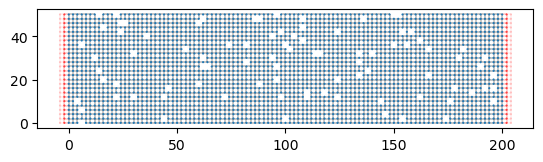

In [13]:
## Creamos el sistema con vacantes:
systf, lead = make_nanoribbon_vacants(L=200, W=50, a=2, cvac = 0.97);
kwant.plot(systf);

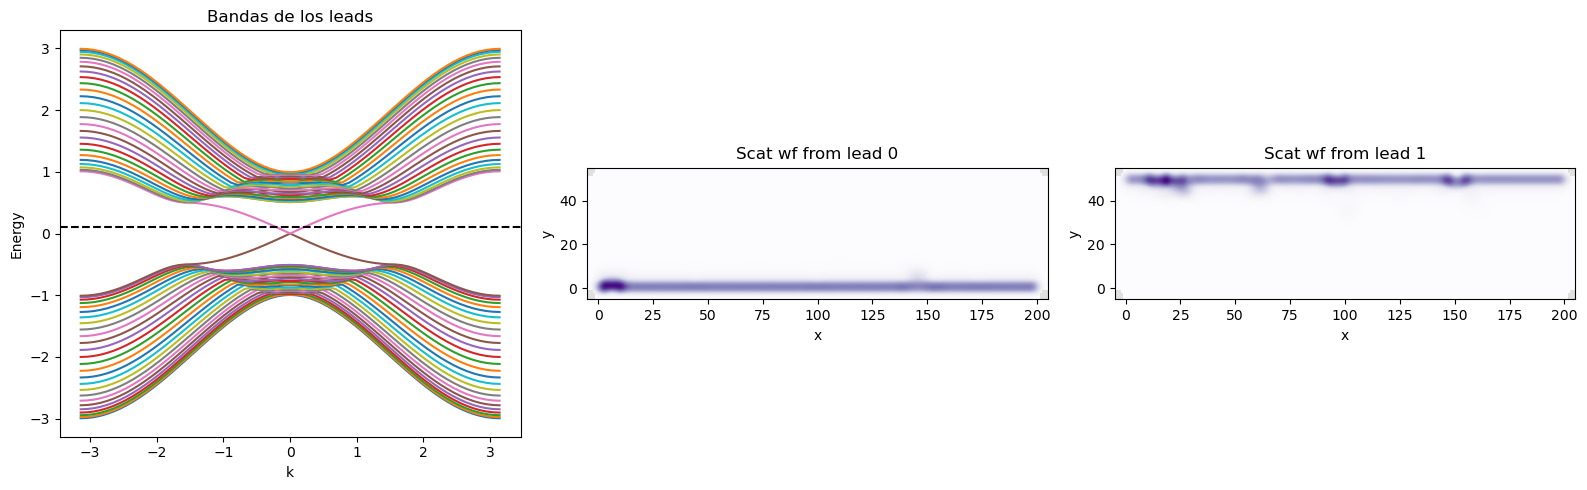

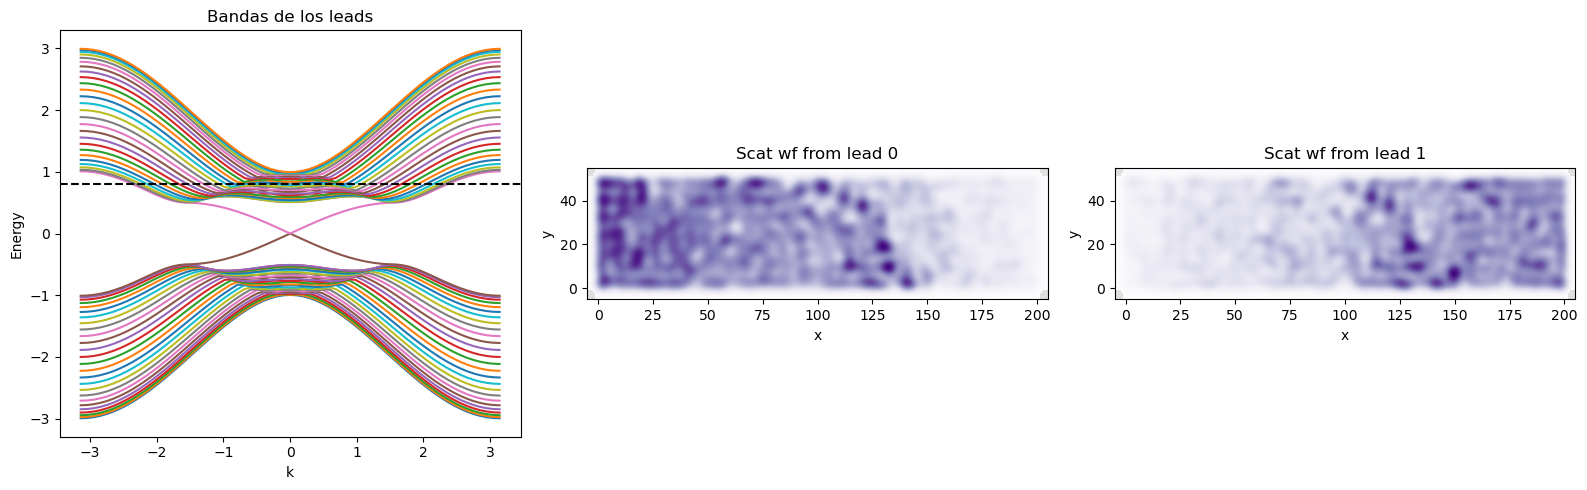

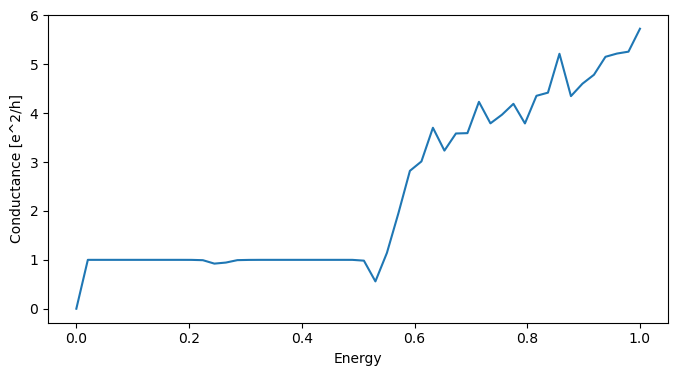

In [14]:
params = dict(A = 1, B = 2,  M = 1)
en = 0.1
plot_scatwf(systf, en, params)

en = 0.8
plot_scatwf(systf, en, params)

energies = np.linspace(0, 1)
cond = conductance(systf, energies, params, lead_out = 1, lead_in = 0)

##  <span style="color:orange">Ejercicio 5: </span>
Prueba a modificar la concentración de vacantes. Cuál es el valor máximo de concentración para perder la cuantización del estado topológico?

##  <span style="color:orange">Ejercicio 6 (avanzado, solución debajo): </span>
A partir de `plot_scatwf`, modifica el código para pintar las corrientes.

Pista: en vez de `kwant.operator.Density` hay que emplear `kwant.operator.Current`

Más info aquí:
https://kwant-project.org/doc/1/reference/generated/kwant.operator.Current#kwant.operator.Current

https://kwant-project.org/doc/1/reference/generated/kwant.plotter.current

In [15]:
def plot_current(syst, en, params):
    # Calculate the scattering states at energy 'en' coming from the left (numbered as 0) lead, and the associated particle current.
    psi = kwant.wave_function(syst, energy=en, params=params)(0)
    J = kwant.operator.Current(syst).bind(params=params)
    current = sum(J(p) for p in psi)

    # The bands:
    fig = plt.figure(figsize=(16, 5))
    ax1 = fig.add_subplot(131); ax2 = fig.add_subplot(132); ax3 = fig.add_subplot(133);
    kwant.plotter.bands(syst.leads[0], params = params, ax = ax1);
    ax1.axhline(y = en, color= 'k', ls = '--')
    ax1.set_title('Bandas de los leads')

    ax2.set_title('Current from the left lead')
    kwant.plotter.current(syst, current, ax = ax2, cmap = 'Blues');

    # Calculate the scattering states at energy en coming from the right(1) lead
    psi = kwant.wave_function(syst, energy=en, params=params)(1)
    J = kwant.operator.Current(syst).bind(params=params)
    current = sum(J(p) for p in psi)
    ax3.set_title('Current from the right lead')
    kwant.plotter.current(syst, current, ax = ax3, cmap = 'Blues');

    ax1.set_xlabel('k'); ax1.set_ylabel('Energy')
    for ax in [ax2, ax3]:
        ax.set_xlabel('x'); ax.set_ylabel('y');
    plt.show();

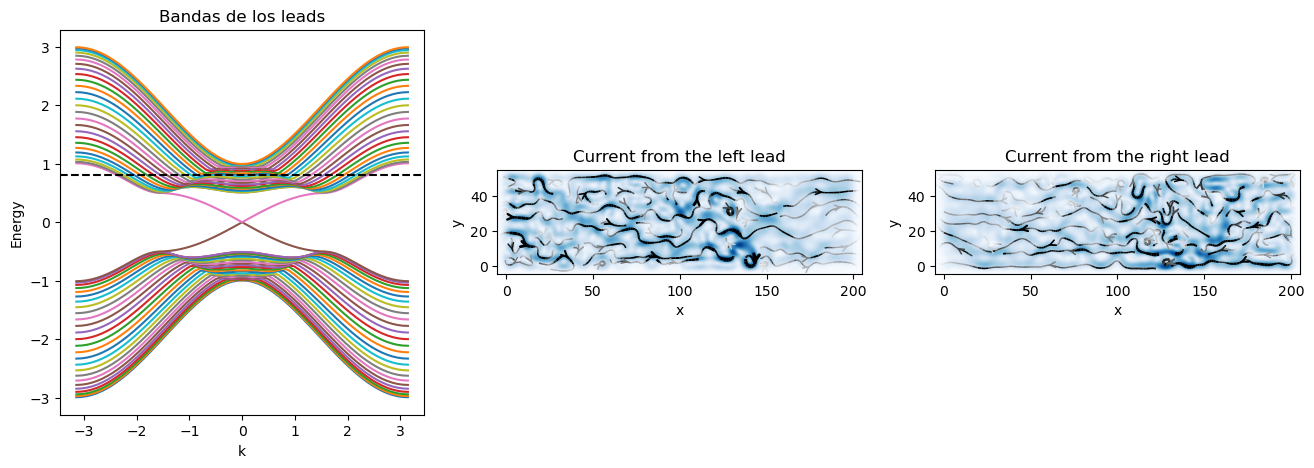

In [16]:
plot_current(systf, en, params)

## EInclusión de impurezas:
Consideremos ahora el caso de un sistema con impurezas, para ello vamos a introducir otro método que es emplear funciones que dependen de las coordenadas espaciales en el Hamiltoniano

In [17]:
## Hamiltoniano con V(x,y)
ham = """
   M * sigma_z - B * (k_x**2 + k_y**2) * sigma_z
   + A * k_x * sigma_x
   - A * k_y * sigma_y
"""
hamDis = """
   M * sigma_z - B * (k_x**2 + k_y**2) * sigma_z
   + A * k_x * sigma_x
   - A * k_y * sigma_y
   + V(x,y) * sigma_0
"""
hamDis = kwant.continuum.sympify(hamDis)

def make_nanoribbonDis(L, W, a):

    # 1) inicializamos un Builder y discretizamos el modelo
    # discretizamos en una red cuadrada de constante a
    modelDis = kwant.continuum.discretize(hamDis, grid=a)
    model = kwant.continuum.discretize(ham, grid=a)

    # 2) rellenamos el sistema con sitios de la red

    def shape_nanoribbon(site):
        x, y, = site.pos
        return 0 <= x <= L and 0 <= y <= W

    syst = kwant.Builder()

    ## El comando fill es el que emplearemos en este caso. (0,0) es el sitio por el que se empezará a rellenar el sistema
    syst.fill(modelDis, shape_nanoribbon, (0, 0))

    # 3) Creamos el lead de contacto:
    # En este caso añadimos la simetría traslacional en -x

    lead = kwant.Builder(kwant.TranslationalSymmetry([-a, 0]), )

    def shape_lead(site):
        x, y = site.pos
        return 0 <= y <= W

    lead.fill(model, shape_lead, (0, 0))
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())

    ## Como output sacamos el sistema finalizado y el lead izquierdo
    return syst.finalized(),  lead.finalized()

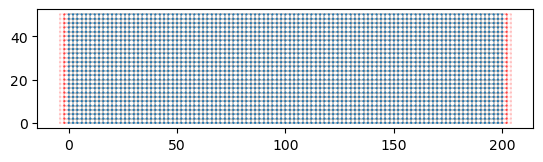

In [18]:
## Creamos el sistema con vacantes:
systf, lead = make_nanoribbonDis(L=200, W=50, a=2);
kwant.plot(systf);

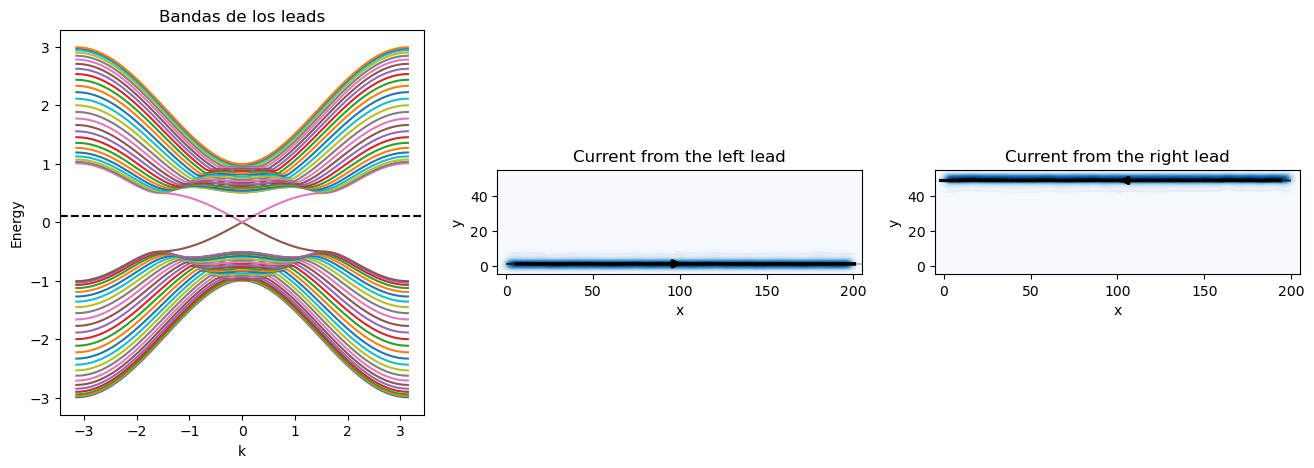

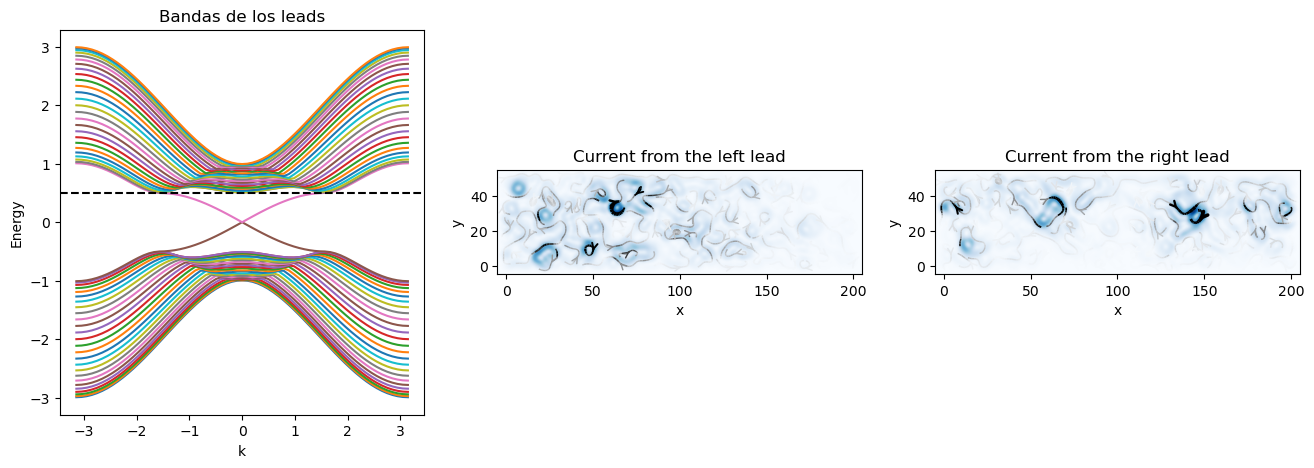

In [19]:
V0 = 0.8
def Vfunc(x,y):
    return V0*(np.random.rand()-0.5)
params = dict(A = 1, B = 2,  M = 1, V = Vfunc)
en = 0.1
plot_current(systf, en, params);
en = 0.5
plot_current(systf, en, params);

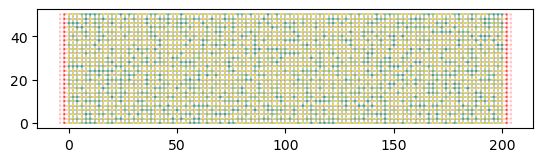

In [20]:
from matplotlib import cm
kwant.plot(systf, site_color = lambda i: cm.viridis(np.abs(systf.hamiltonian(i,i, params = dict(**params)))[0,0]));